# All Modules Functionality Workbook

This notebook demonstrates all steps of the workflow: fetching, transforming, training, inference, and simulation.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Check local directory is 05-deployment-and-automation
!cd

C:\Users\msofy\Downloads\stock-markets-analytics-zoomcamp-project\Project\Source data with new feature


In [9]:
# workflow settings
FETCH_REPO = False
TRANSFORM_DATA = False
TRAIN_MODEL = False

# 1) Fetching data from API / Loading from a local storage

In [10]:
from scripts.data_repo import DataRepository

repo = DataRepository()

In [11]:
if FETCH_REPO:
  # Fetch All 3 datasets for all dates from APIs
  repo.fetch()
  # save data to a local dir
  repo.persist(data_dir='local_data/')
else:
  # OR Load from disk
  repo.load(data_dir='local_data/')  

  
# DEBUG: Separate fetching of the datasets (YFinance-Tickers, YFinance-Indexes, FRED-Macro)
# repo.fetch_tickers()
# repo.fetch_indexes()
# repo.fetch_macro()

In [12]:
# NOT WORKING YET - need to move all data transformations to Transform

# # Test fetching data with a specific min_date
# min_date = '2024-06-01'
# print(f"\nFetching data from {min_date}:")
# repo.fetch(min_date=min_date)

# repo.ticker_df.Ticker.nunique()

In [13]:
repo.ticker_df.Date.agg({'min','max','count'})

min      1970-01-02
count        203221
max      2024-07-05
Name: Date, dtype: object

In [14]:
repo.ticker_df.Ticker.nunique()

25

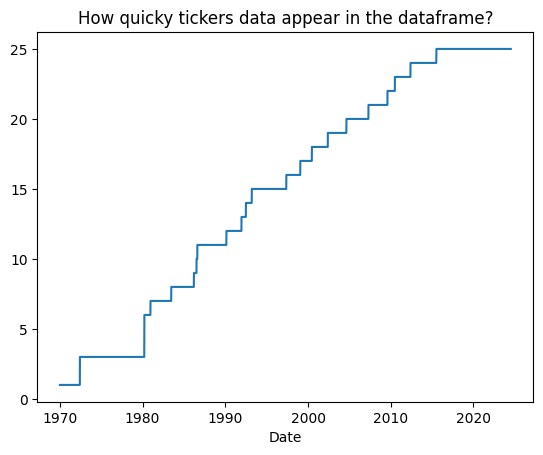

In [15]:
import matplotlib.pyplot as plt
repo.ticker_df.groupby('Date')['Open'].agg('count').plot()
plt.title('How quicky tickers data appear in the dataframe?')
plt.show()


In [16]:
repo.indexes_df.shape

(13747, 55)

In [17]:
repo.indexes_df.tail(1)

growth_snp500_1d  growth_snp500_3d  growth_snp500_7d  \
Date                                                               
2024-07-05          1.005449          1.016822          1.017898   

            growth_snp500_30d  growth_snp500_90d  growth_snp500_365d  \
Date                                                                   
2024-07-05           1.046187           1.098167            1.401393   

            growth_dax_1d  growth_dax_3d  growth_dax_7d  growth_dax_30d  ...  \
Date                                                                     ...   
2024-07-05       1.001353       1.017143       1.017637        0.988342  ...   

            growth_brent_oil_7d  growth_brent_oil_30d  growth_brent_oil_90d  \
Date                                                                          
2024-07-05             1.023056              1.049349              1.053799   

            growth_brent_oil_365d  growth_btc_usd_1d  growth_btc_usd_3d  \
Date                                                                      
2024-07-05               0.986166           0.994466           0.913482   

            growth_btc_usd_7d  growth_btc_usd_30d  growth_btc_usd_90d  \
Date                                                                    
2024-07-05           0.939361            0.797132            0.822432   

            growth_btc_usd_365d  
Date                             
2024-07-05             1.894471  

[1 rows x 55 columns]

In [18]:
repo.macro_df.tail(1)

DGS1  DGS5       Date    Quarter  gdppot_us_yoy  gdppot_us_qoq  \
DATE                                                                         
2024-07-03  5.04  4.33 2024-07-03 2024-07-01       0.020675       0.005201   

                Month  FEDFUNDS  cpi_core_yoy  cpi_core_mom  DGS10  
DATE                                                                
2024-07-03 2024-07-01      5.33      0.034111      0.001631   4.36

# 2) Transform all input fields (data_repo dfs) to one dataframe

In [19]:
from scripts.transform import TransformData

transformed =  TransformData(repo = repo)

if TRANSFORM_DATA:
  transformed.transform()
  transformed.persist(data_dir='local_data/')
else:
  transformed.load(data_dir='local_data/')

In [20]:
transformed.transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138356 entries, 4816 to 8063
Columns: 216 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns, UTC](1), datetime64[ns](2), float64(140), int32(69), int64(3), object(1)
memory usage: 192.6+ MB


In [21]:
transformed.transformed_df.tail(2)

Open       High        Low      Close  Adj Close     Volume Ticker  \
8062  76.839996  77.040001  76.070000  76.260002  76.260002  4906700.0   SBUX   
8063  76.239998  76.269997  75.419998  76.050003  76.050003  9660800.0   SBUX   

      Year  Month_x  Weekday  ... growth_brent_oil_7d  growth_brent_oil_30d  \
8062  2024        7        2  ...            1.015463              1.043364   
8063  2024        7        4  ...            1.023056              1.049349   

      growth_brent_oil_90d  growth_brent_oil_365d  growth_btc_usd_1d  \
8062              1.070081               0.996691           0.970093   
8063              1.053799               0.986166           0.994466   

      growth_btc_usd_3d  growth_btc_usd_7d  growth_btc_usd_30d  \
8062           0.960044           0.989519            0.874560   
8063           0.913482           0.939361            0.797132   

      growth_btc_usd_90d  growth_btc_usd_365d  
8062            0.878338             1.955122  
8063            0.822432             1.894471  

[2 rows x 216 columns]

In [22]:
# last 3 days of the data
transformed.transformed_df.tail(3)['Date']

8061   2024-07-02 00:00:00+00:00
8062   2024-07-03 00:00:00+00:00
8063   2024-07-05 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

# 3) Train the best model 
* Model : Random Forest(max_depth=17, n_estimators=200)

In [23]:
from scripts.train import TrainModel
import warnings

# Suppress all warnings (not recommended in production unless necessary)
warnings.filterwarnings("ignore")

trained = TrainModel(transformed=transformed)

if TRAIN_MODEL:
  trained.prepare_dataframe() # prepare dataframes
  trained.train_random_forest() # train the model
  trained.persist(data_dir='local_data/') # save the model to disk
else:
  trained.prepare_dataframe() # prepare dataframes (incl. for inference)
  trained.load(data_dir='local_data/')


Prepare the dataframe: define feature sets, add dummies, temporal split
length: X_train (92106, 233),  X_validation (23175, 233), X_test (23075, 233)
  X_train_valid = (115281, 233),  all combined: X_all (138356, 233)


In [24]:
# resulting df
trained.df_full.tail(2)

Open       High        Low      Close  Adj Close     Volume Ticker  \
8062  76.839996  77.040001  76.070000  76.260002  76.260002  4906700.0   SBUX   
8063  76.239998  76.269997  75.419998  76.050003  76.050003  9660800.0   SBUX   

      Year  Month_x Weekday  ... Ticker_NFLX  Ticker_NVDA  Ticker_PEP  \
8062  2024        7       2  ...           0            0           0   
8063  2024        7       4  ...           0            0           0   

      Ticker_PYPL  Ticker_QCOM  Ticker_SBUX  Ticker_TMUS  Ticker_TSLA  \
8062            0            0            1            0            0   
8063            0            0            1            0            0   

      Ticker_TXN  split  
8062           0   test  
8063           0   test  

[2 rows x 261 columns]

In [25]:
trained.model

RandomForestClassifier(max_depth=17, n_estimators=200, n_jobs=-1,
                       random_state=42)

# 4) Inference

In [26]:
prediction_name='pred_rf_best'
trained.make_inference(pred_name=prediction_name)

Making inference


In [27]:
trained.df_full

Open       High        Low      Close  Adj Close       Volume  \
4816   0.936384   1.004464   0.907924   0.999442   0.844981  535796800.0   
4817   0.966518   0.987723   0.903460   0.915179   0.773741  512377600.0   
4818   0.926339   0.987165   0.919643   0.928571   0.785063  778321600.0   
4819   0.947545   0.955357   0.848214   0.848214   0.717125  767972800.0   
4820   0.861607   0.901786   0.852679   0.888393   0.751094  460734400.0   
...         ...        ...        ...        ...        ...          ...   
8059  78.720001  78.879997  77.610001  77.849998  77.849998   13207500.0   
8060  77.989998  78.220001  76.779999  77.129997  77.129997    6767600.0   
8061  77.120003  77.209999  76.279999  76.830002  76.830002    8854100.0   
8062  76.839996  77.040001  76.070000  76.260002  76.260002    4906700.0   
8063  76.239998  76.269997  75.419998  76.050003  76.050003    9660800.0   

     Ticker  Year  Month_x Weekday  ... Ticker_PEP  Ticker_PYPL  Ticker_QCOM  \
4816   AAPL  2000        1       0  ...          0            0            0   
4817   AAPL  2000        1       1  ...          0            0            0   
4818   AAPL  2000        1       2  ...          0            0            0   
4819   AAPL  2000        1       3  ...          0            0            0   
4820   AAPL  2000        1       4  ...          0            0            0   
...     ...   ...      ...     ...  ...        ...          ...          ...   
8059   SBUX  2024        6       4  ...          0            0            0   
8060   SBUX  2024        7       0  ...          0            0            0   
8061   SBUX  2024        7       1  ...          0            0            0   
8062   SBUX  2024        7       2  ...          0            0            0   
8063   SBUX  2024        7       4  ...          0            0            0   

      Ticker_SBUX  Ticker_TMUS  Ticker_TSLA  Ticker_TXN  split  pred_rf_best  \
4816            0            0            0           0  train      0.313215   
4817            0            0            0           0  train      0.374091   
4818            0            0            0           0  train      0.389714   
4819            0            0            0           0  train      0.814504   
4820            0            0            0           0  train      0.798627   
...           ...          ...          ...         ...    ...           ...   
8059            1            0            0           0   test      0.402875   
8060            1            0            0           0   test      0.425146   
8061            1            0            0           0   test      0.399153   
8062            1            0            0           0   test      0.416466   
8063            1            0            0           0   test      0.520842   

      pred_rf_best_rank  
4816               11.0  
4817               15.0  
4818               14.0  
4819                2.0  
4820                3.0  
...                 ...  
8059                5.0  
8060                1.0  
8061                6.0  
8062                5.0  
8063                4.0  

[138356 rows x 263 columns]

In [28]:
COLUMNS = ['Adj Close','Ticker','Date',prediction_name, prediction_name+'_rank']
trained.df_full[trained.df_full[f'{prediction_name}_rank']==1].sort_values(by="Date").tail(10)[COLUMNS]

Adj Close Ticker                      Date  pred_rf_best  \
9564   848.309998   COST 2024-06-21 00:00:00+00:00      0.435225   
8190   200.839996   QCOM 2024-06-24 00:00:00+00:00      0.460530   
8191   202.169998   QCOM 2024-06-25 00:00:00+00:00      0.425946   
13740  213.429993    HON 2024-06-26 00:00:00+00:00      0.422671   
13129  166.259995    PEP 2024-06-27 00:00:00+00:00      0.437624   
8655    47.106430   CSCO 2024-06-28 00:00:00+00:00      0.444115   
8060    77.129997   SBUX 2024-07-01 00:00:00+00:00      0.425146   
6401   122.669998   NVDA 2024-07-02 00:00:00+00:00      0.436942   
13133  162.600006    PEP 2024-07-03 00:00:00+00:00      0.431226   
8659    46.650002   CSCO 2024-07-05 00:00:00+00:00      0.544385   

       pred_rf_best_rank  
9564                 1.0  
8190                 1.0  
8191                 1.0  
13740                1.0  
13129                1.0  
8655                 1.0  
8060                 1.0  
6401                 1.0  
13133                1.0  
8659                 1.0

In [30]:
result_df = trained.df_full[trained.df_full[f'{prediction_name}_rank'] <= 2].sort_values(by=["Date", f'{prediction_name}_rank']).tail(10)[COLUMNS]
print(result_df)

         Adj Close Ticker                      Date  pred_rf_best  \
8655     47.106430   CSCO 2024-06-28 00:00:00+00:00      0.444115   
11164    30.969999   INTC 2024-06-28 00:00:00+00:00      0.424496   
8060     77.129997   SBUX 2024-07-01 00:00:00+00:00      0.425146   
11165   157.690002    AMD 2024-07-01 00:00:00+00:00      0.415395   
6401    122.669998   NVDA 2024-07-02 00:00:00+00:00      0.436942   
3750   1657.479980   AVGO 2024-07-02 00:00:00+00:00      0.430836   
13133   162.600006    PEP 2024-07-03 00:00:00+00:00      0.431226   
9653    460.769989   MSFT 2024-07-03 00:00:00+00:00      0.431008   
8659     46.650002   CSCO 2024-07-05 00:00:00+00:00      0.544385   
13134   164.389999    PEP 2024-07-05 00:00:00+00:00      0.538515   

       pred_rf_best_rank  
8655                 1.0  
11164                2.0  
8060                 1.0  
11165                2.0  
6401                 1.0  
3750                 2.0  
13133                1.0  
9653                 2.0

# 5) Trading Simulation

In [33]:
# Trade simulation logic
for index, row in result_df.iterrows():
# Access relevant columns for trade simulation
    ticker = row['Ticker']
    date = row['Date']
    prediction = row[prediction_name]

In [39]:
# Trade logic implementation
for index, row in repo.ticker_df.iterrows():
# Buy when SMA10 crosses above SMA20 and predicted growth_future_5d is positive
    if row['SMA10'] > row['SMA20'] and row['is_positive_growth_5d_future'] == 1:
        print(f"Buy {row['Ticker']} on {row['Date']}")
# Sell when growth_future_10d is negative
    if row['is_positive_growth_10d_future'] == 0:
        print(f"Sell {row['Ticker']} on {row['Date']}")

Sell AAPL on 1980-12-23
Sell AAPL on 1980-12-24
Sell AAPL on 1980-12-26
Sell AAPL on 1980-12-29
Sell AAPL on 1980-12-30
Sell AAPL on 1980-12-31
Sell AAPL on 1981-01-02
Sell AAPL on 1981-01-05
Sell AAPL on 1981-01-06
Buy AAPL on 1981-01-12
Buy AAPL on 1981-01-13
Buy AAPL on 1981-01-14
Buy AAPL on 1981-01-15
Sell AAPL on 1981-01-15
Sell AAPL on 1981-01-16
Sell AAPL on 1981-01-19
Sell AAPL on 1981-01-20
Sell AAPL on 1981-01-21
Sell AAPL on 1981-01-22
Sell AAPL on 1981-01-23
Sell AAPL on 1981-01-26
Sell AAPL on 1981-01-27
Sell AAPL on 1981-01-28
Sell AAPL on 1981-01-29
Buy AAPL on 1981-01-30
Sell AAPL on 1981-01-30
Sell AAPL on 1981-02-02
Sell AAPL on 1981-02-03
Sell AAPL on 1981-02-04
Sell AAPL on 1981-02-05
Sell AAPL on 1981-02-06
Sell AAPL on 1981-02-09
Sell AAPL on 1981-02-10
Sell AAPL on 1981-02-11
Sell AAPL on 1981-02-18
Sell AAPL on 1981-02-23
Sell AAPL on 1981-02-24
Sell AAPL on 1981-02-25
Sell AAPL on 1981-02-26
Sell AAPL on 1981-02-27
Sell AAPL on 1981-03-02
Sell AAPL on 1981-03-